In [2]:
import numpy as np
import scipy 
import scipy.sparse as sparse
import no_J_free_pump as api
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(0)

In [3]:
# Initialize parameters and SDR constraint
N_omega = 11
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 2*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [4]:
# When the pump is a Gaussian, the Schmidt modes become an anti-diagonal identit...
beta_vec = np.random.random(2*N_omega - 1)#np.exp(-(np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)/0.4)#
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = beta/np.sqrt(np.trace(beta.conj().T@beta))
beta_weight = 10
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
n = 0.25*np.trace((W_plus[-1] - W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1]))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
V, D, W = scipy.linalg.svd(W_plus[-1] - W_minus[-1])
rand_unitary = V@W
X = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta])
Y = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T

In [5]:
# Create constraint matrices
constr_sympl = []
constr_dyn = []
constr_unitary = []
photon_end = api.photon_nbr_constr(N_omega, N_z, n)
photon_nbr_prev = api.photon_nbr_prev_points(N_omega, N_z)
fix_beta = []
for i in range(len(projections)):
    sympl_real, sympl_imag = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    dyn_real_plus, dyn_imag_plus, dyn_real_minus, dyn_imag_minus = api.get_dynamics_sdr(omega, z, projections[i], n, beta_weight)
    unitary_constr_real, unitary_constr_imag = api.unitary_constr(N_omega, N_z, projections[i])
    fix_beta_real, fix_beta_imag = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    constr_sympl += sympl_real + sympl_imag
    constr_dyn += dyn_real_plus + dyn_imag_plus + dyn_real_minus + dyn_imag_minus
    constr_unitary += [unitary_constr_real + unitary_constr_imag]
    fix_beta += [fix_beta_imag, fix_beta_real]
constr_unitary_trace = api.trace_unitary_mat(N_omega, N_z)
Q_list = api.get_standard_Q(N_omega) + api.get_Q_list(N_omega, 100) + api.get_hermite_Q_list(omega, 1/0.4, 6)
Q_constr_mat = api.ineq_real_any_unitary(N_omega, N_z, Q_list)
imag_obj_f = api.imag_obj_f(N_omega, N_z)
pump_limit = api.limit_pump_power(N_omega, N_z)
hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
left_sdr_constr, right_sdr_constr, substr_plus, substr_minus = api.obj_f_psd(N_omega, N_z)
substr_cst = -(0.5/n)*np.eye(N_omega)

In [6]:
# Summing all constraints together
constraints_list = constr_sympl + constr_dyn + constr_unitary + [pump_limit] + fix_beta

In [7]:
[(np.trace(Y.conj().T@constraints_list[i]@Y), i) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 8*10**-6]

[]

In [8]:
[np.trace(Y.conj().T@Q_constr_mat[i]@Y) for i in range(len(Q_constr_mat)) if np.trace(Y.conj().T@Q_constr_mat[i]@Y) < -0]

[]

In [9]:
[np.trace(Y.conj().T@Q_constr_mat[i]@Y) for i in range(len(Q_constr_mat)) if np.trace(Y.conj().T@Q_constr_mat[i]@Y) < -10**-12]

[]

In [10]:
# Objective function
obj_f = api.obj_f_sdr(N_omega,N_z, n)

In [11]:
# CVXPY model
# The convergence really happens when the photon pair number is fixed
# If even 1 of these constraint is missing, everything goes to shit
variable = cp.Variable(shape = ((2*N_z + 3)*N_omega,(2*N_z + 3)*N_omega), hermitian = True)
constraints = [variable >> 0]
# Constraints about symplectic structure of propagators
constraints += [cp.real(cp.trace(constr_sympl[i]@variable)) == 0 for i in range(len(constr_sympl))]
# Constraints about dynamics
constraints += [cp.real(cp.trace(constr_dyn[i]@variable)) == 0 for i in range(len(constr_dyn))]
# Constraint that the top matrix is unitary
constraints += [cp.real(cp.trace(constr_unitary[i]@variable)) == 0 for i in range(len(constr_unitary))]
# Constraint that defines the problem into a semidefinite relaxation
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
# Constraint that says the mean photon number at next step is bigger than previous
constraints += [cp.real(cp.trace(photon_nbr_prev[i]@variable)) >= 0 for i in range(len(photon_nbr_prev))]
# Constraint that state the pump is fixed (right now, it makes that the pump is real)
constraints += [cp.real(cp.trace(fix_beta[i]@variable)) == 0 for i in range(len(fix_beta))]


# Constraint that makes the matrix inside objective function positive semidefinite
#constraints += [0.5*left_sdr_constr.conj().T@variable@right_sdr_constr>>0]# - (substr_plus.conj().T@variable@substr_plus + substr_minus.conj().T@variable@substr_minus + substr_cst) >> 0]


# B is the best unitary matrix (dont touch)
#constraints += [cp.real(cp.trace(Q_constr_mat[i]@variable)) >= 0 for i in range(len(Q_constr_mat))]

# Constraint that the pump is hankel matrix
#constraints += [cp.real(cp.trace(hankel_constr[i]@variable)) == 0 for i in range(len(hankel_constr))]

# Constraint that defines the photon number at end of waveguide
constraints.append(cp.real(cp.trace(photon_end@variable)) == 0)

# Constraint that gives imaginary part of objective function 0
#constraints.append(cp.real(cp.trace(imag_obj_f@variable)) == 0)

# Constraint that make the Frobenius norm of beta equal to 1
constraints.append(cp.real(cp.trace(pump_limit@variable)) == 0)
# Constraint to state the trace of unitary is 1
#constraints.append(cp.real(cp.trace(constr_unitary_trace@variable)) == 0)
# Constraint to limit the objective function value
#constraints.append(cp.real(cp.trace(obj_f@variable)) >= 1.)
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f@variable))), constraints)

In [12]:
problem.solve(solver = cp.SCS, verbose = True, max_iters = 25*10**4, eps_abs = 1.0e-8, eps_rel = 1.0e-8, eps_infeas = 1.0e-8)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 24 05:38:24 PM: Your problem has 5929 variables, 1940 constraints, and 0 parameters.
(CVXPY) Mar 24 05:38:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 24 05:38:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 24 05:38:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 24 05:38:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 24 05:38:24 PM: Compiling problem (target solver=SCS).


/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-2.247407686794342

In [1]:
# Get the optimal variable as numpy array
end_product = variable.value

NameError: name 'variable' is not defined

In [14]:
np.trace(Y.conj().T@obj_f@Y)

(2.0892664839334563+3.638853541404474e-18j)

In [15]:
[(np.trace(constraints_list[i]@end_product), i) for i in range(len(constraints_list)) if np.abs(np.trace(constraints_list[i]@end_product)) > 10**-3]

[]

In [17]:
# Get elements of the optimized_result
opt_unit = end_product[:N_omega, (2*N_z + 2)*N_omega:]
opt_B_U_plus_dagger = end_product[:N_omega, (N_z)*N_omega:(N_z + 1)*N_omega]
opt_B_U_minus_dagger = end_product[:N_omega, (2*N_z)*N_omega:(2*N_z + 1)*N_omega]
opt_U_plus_dagger_1 = end_product[N_z*N_omega:(N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_plus_dagger_0 = end_product[(N_z - 1)*N_omega:(N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_1 = end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_0 = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_beta = end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
quad_part = end_product[:(2*N_z + 2)*N_omega, :(2*N_z + 2)*N_omega]
lin_part = end_product[:(2*N_z + 2)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]

Text(0, 0.5, 'Frequency index')

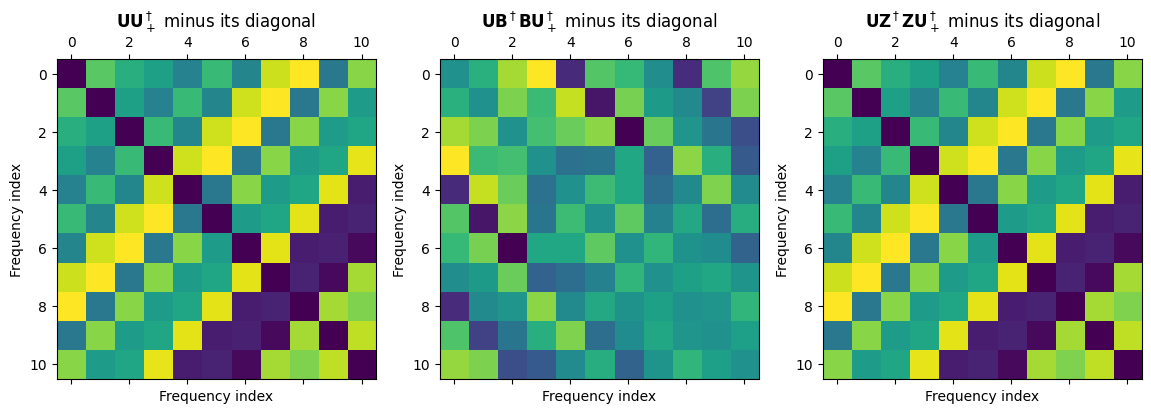

In [22]:
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(14, 8))
ax1.matshow(np.real(end_product[N_z*N_omega:(N_z + 1)*N_omega, N_z*N_omega:(N_z + 1)*N_omega] - np.diag(np.diag(end_product[N_z*N_omega:(N_z + 1)*N_omega, N_z*N_omega:(N_z + 1)*N_omega]))))
ax1.set_title(r'$\mathbf{U}\mathbf{U}_+^\dagger$ minus its diagonal')
ax1.set_xlabel('Frequency index')
ax1.set_ylabel('Frequency index')
ax2.matshow(np.real(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger - np.diag(np.diag(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger))))
ax2.set_title(r'$\mathbf{U}\mathbf{B}^\dagger\mathbf{B}\mathbf{U}_+^\dagger$ minus its diagonal')
ax2.set_xlabel('Frequency index')
ax2.set_ylabel('Frequency index')
ax3.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1 - np.diag(np.diag(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))
ax3.set_title(r'$\mathbf{U}\mathbf{Z}^\dagger\mathbf{Z}\mathbf{U}_+^\dagger$ minus its diagonal')
ax3.set_xlabel('Frequency index')
ax3.set_ylabel('Frequency index')

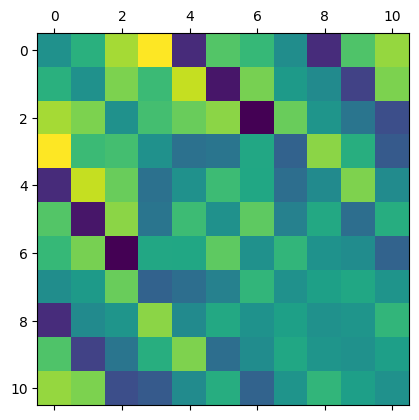

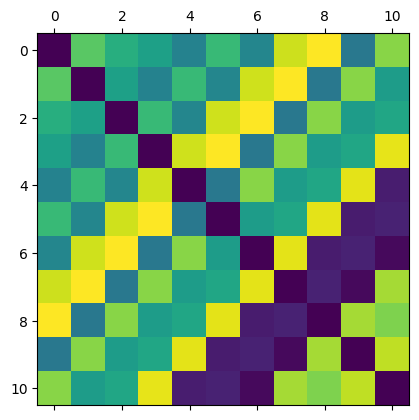

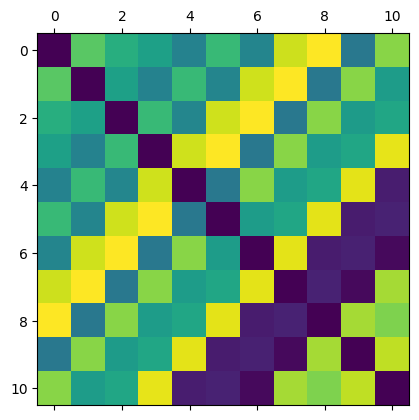

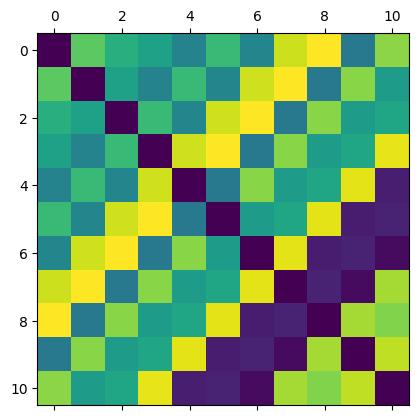

In [18]:
# When B dagger (U_plus - U_minus) is not enforced. B is clearly not unitary
plt.matshow(np.real(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger - np.diag(np.diag(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger))))
plt.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1 - np.diag(np.diag(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))
plt.matshow(np.real(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega] - np.diag(np.diag(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega]))))
plt.matshow(np.real(W_plus[1]@W_plus[1].conj().T - np.diag(np.diag(W_plus[1]@W_plus[1].conj().T))))

In [17]:
pump = np.array(list(opt_beta[0]) + list(opt_beta[-1]))
test_W_plus = scipy.linalg.expm((delta_k + beta_weight*opt_beta)*z[-1])
test_W_minus = scipy.linalg.expm((delta_k - beta_weight*opt_beta)*z[-1])

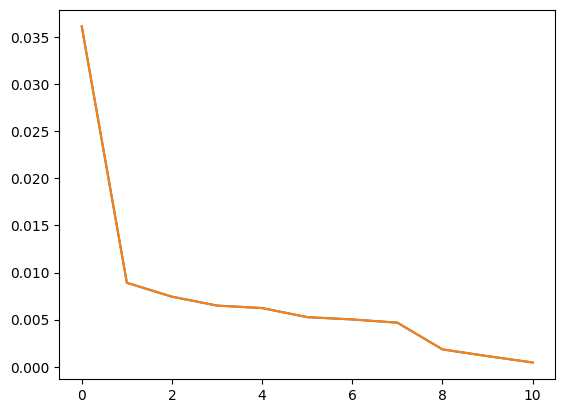

In [18]:
# Same thing, just a matter of divided by 50
plt.plot(scipy.linalg.svd(test_W_plus - test_W_minus)[1])
plt.plot(scipy.linalg.svd(W_plus[1] - W_minus[1])[1]/50)

In [19]:
eig_vals, eig_vec = scipy.linalg.eig(end_product)
eig_vec = eig_vec.T
should_be = eig_vec[0]*np.sqrt(eig_vals[0])
for i in range(1, N_omega):
    should_be = np.vstack([should_be, np.sqrt(eig_vals[i])*eig_vec[i]])
should_be = should_be.T

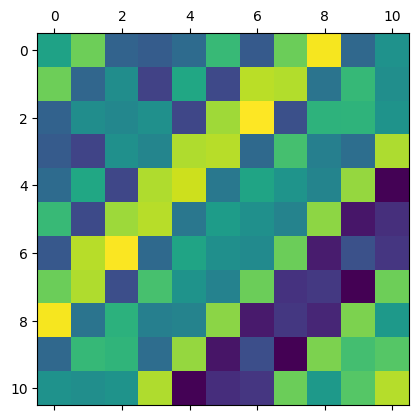

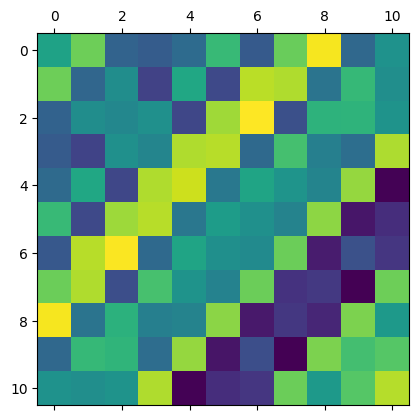

In [20]:
# Comparing the bloc of B_U_plus_dagger and B@U_plus_dagger
plt.matshow(np.real(opt_unit@W_plus[1].conj().T))
plt.matshow(np.real(opt_B_U_plus_dagger))

In [21]:
np.sqrt(np.trace((opt_unit.conj().T@opt_unit - np.eye(N_omega)).conj().T@(opt_unit.conj().T@opt_unit - np.eye(N_omega))))

(2.777837915573082+0j)

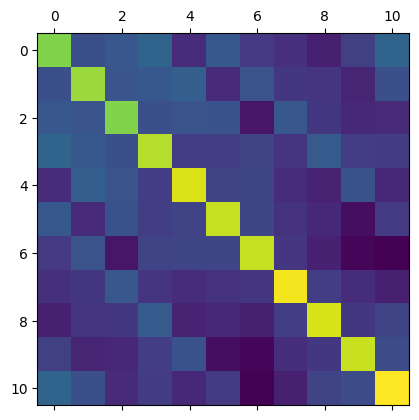

In [22]:
# The unitary matrix
plt.matshow(np.real(opt_unit.conj().T@opt_unit))

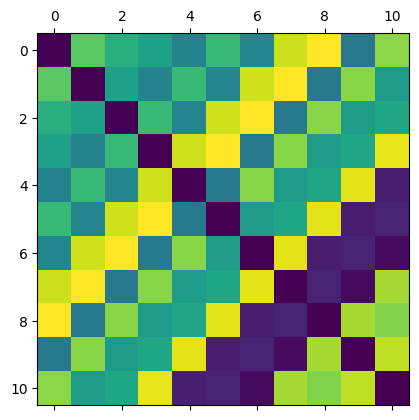

In [23]:
plt.matshow(np.abs(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1) - np.diag(np.diag(np.abs(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))

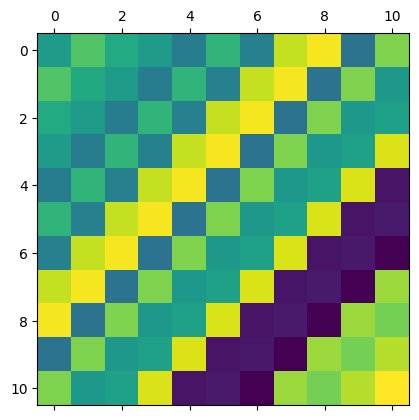

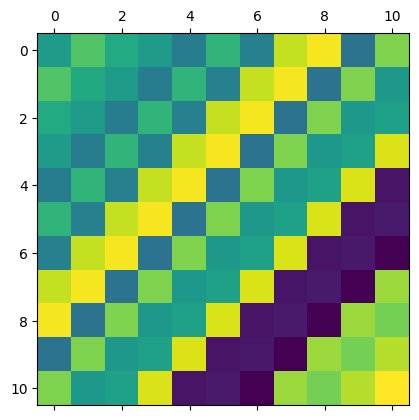

In [24]:
# Comparing optimal U_plus and theoretical U_plus
plt.matshow(np.real(W_plus[1]) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))
plt.matshow(np.real(opt_U_plus_dagger_1) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))

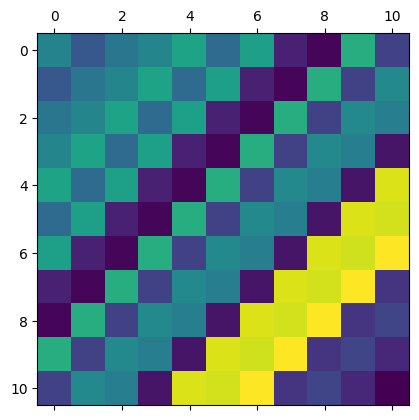

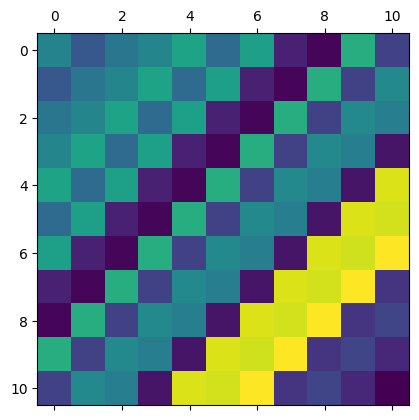

In [25]:
# Comparing optimal U_minus and theoretical U_minus
plt.matshow(np.real(W_minus[1]) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))
plt.matshow(np.real(opt_U_minus_dagger_1) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))

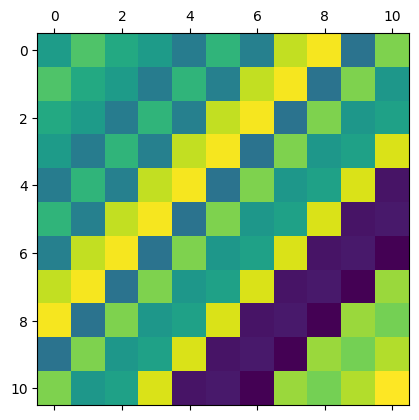

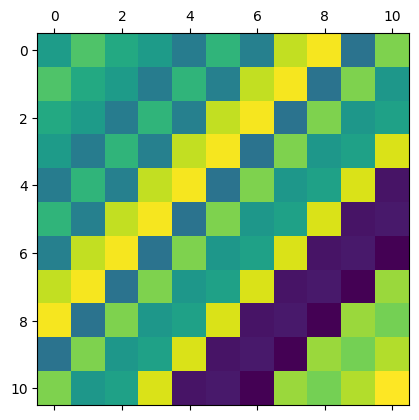

In [26]:
# Comparing the optimized beta and theoretical beta
plt.matshow(np.real(opt_beta))
plt.matshow(np.real(beta))

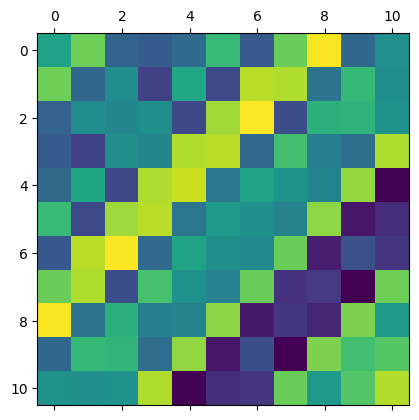

In [27]:
plt.matshow(np.real(opt_unit))

In [28]:
S, V, D = scipy.linalg.svd(W_plus[1] - W_minus[-1])

In [29]:
sum(V)

4.178532967866912

In [30]:
unitary_mat = end_product[:N_omega, (2*N_z + 2)*N_omega:]

In [31]:
np.diag(unitary_mat.conj().T@unitary_mat)

array([0.1638479 +0.j, 0.17095261+0.j, 0.16412833+0.j, 0.17815692+0.j,
       0.18819981+0.j, 0.18173881+0.j, 0.18186537+0.j, 0.19417399+0.j,
       0.18657243+0.j, 0.18271941+0.j, 0.1973174 +0.j])

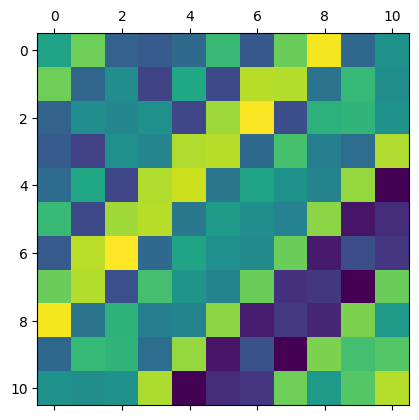

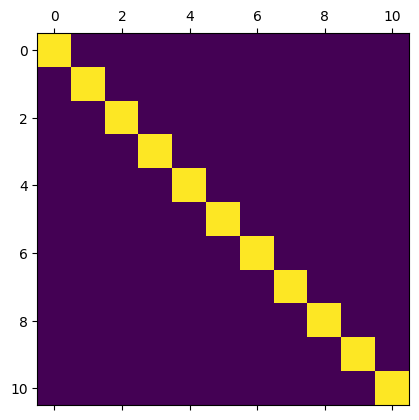

In [32]:
plt.matshow(np.real(unitary_mat.conj().T@W_plus[1]))
plt.matshow(np.real(np.real(W_plus[1])))

In [33]:
sum(V)/np.sqrt(n)

(208.91742683067596+0j)